Logs   
- [2023/03/08]   
  Restart this notebook if you change the scratch library

In [42]:
import networkx as nx
import matplotlib.pyplot as plt

from typing import NamedTuple, Dict, List
from collections import deque
from IPython.display import display

Path = List[int]


In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

Several important terms in networks:

- nodes
- edges
- undirected
- directed

## Betweenness Centrality

The reason why we need to use *betweeness centrality* is to capture who
is the key connector for given two peoples. The notion of *degree centrality*
cannot capture this feature.

In [9]:
class User(NamedTuple):
  id_: int
  name: str

users = [User(0, "Hero"), User(1, "Dunn"), User(2, "Sue"), User(3, "Chi"),
         User(4, "Thor"), User(5, "Clive"), User(6, "Hicks"),
         User(7, "Devin"), User(8, "Kate"), User(9, "Klein")]

friend_pairs = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4),
                (4, 5), (5, 6), (5, 7), (6, 8), (7, 8), (8, 9)]

### The DataSciencester network

The DataSciencester network


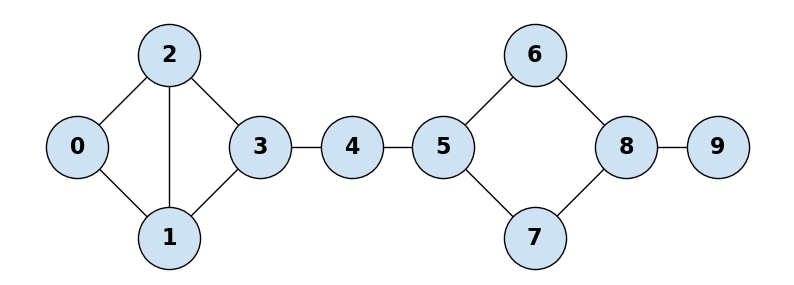

In [24]:
G = nx.Graph()
[G.add_node(user.id_) for user in users]
G.add_edges_from(friend_pairs)

fig, ax = plt.subplots(figsize=(10, 10))

node_pos = {
  0: (0, 2), 1: (1, 1), 2: (1, 3), 3: (2, 2), 4: (3, 2),
  5: (4, 2), 6: (5, 3), 7:(5, 1), 8: (6, 2), 9: (7, 2)}

nx.draw(G, pos=node_pos, with_labels=True, font_weight="bold", 
  node_color="#cfe2f3", node_size=2000, 
  edgecolors="k", ax=ax, font_size=16)

# nx.draw(G, with_labels=True, font_weight="bold", 
#   node_color="#cfe2f3", node_size=700, 
#   edgecolors="k", ax=ax)

ax.set_aspect("equal")
ax.set_ylim([0.6, 3.5])
# ax.set_title("The DataSciencester network")

print("The DataSciencester network")
plt.show(fig)

The friendship data will be easier to handle as a `dict`

In [27]:
# type alias for keeping track of Friendships
Friendships = Dict[int, List[int]]

friendships: Friendships = {user.id_: [] for user in users}

for i, j in friend_pairs:
  friendships[i].append(j)
  friendships[j].append(i)

print(friendships[4])
print(friendships[8])

[3, 5]
[6, 7, 9]


To calculate *betweenness centrality* of node $i$, we add
up, for every other pair of nodes $j$ and $k$, the proportion
of shortest paths between node $j$ and node $k$ that pass through $i$.

Now we have to build a function that can calculate the shortest
paths between all pairs of peple. This algorithm is bread-firsth search.
See the textbook for the complete description

In [45]:
for user in users:
  from_user_id = user.id_
  frontier = deque((from_user_id, friend_id)
                    for friend_id in friendships[from_user_id])
  print(frontier)

deque([(0, 1), (0, 2)])
deque([(1, 0), (1, 2), (1, 3)])
deque([(2, 0), (2, 1), (2, 3)])
deque([(3, 1), (3, 2), (3, 4)])
deque([(4, 3), (4, 5)])
deque([(5, 4), (5, 6), (5, 7)])
deque([(6, 5), (6, 8)])
deque([(7, 5), (7, 8)])
deque([(8, 6), (8, 7), (8, 9)])
deque([(9, 8)])


In [53]:
from_user_id = users[0].id_
frontier = deque((from_user_id, friend_id)
                  for friend_id in friendships[from_user_id])
print(frontier)
frontier.popleft()
print(frontier)
frontier.extend([(2, 3)])
print(frontier)

deque([(0, 1), (0, 2)])
deque([(0, 2)])
deque([(0, 2), (2, 3)])


In [49]:
[[] + [1]]

[[1]]

In [29]:
def shortest_paths_from(from_user_id: int, friendships: Friendships) -> Dict[int, List[Path]]:
  # A dictionary from user_id to `all` shortest paths to that user.
  shortest_paths_to: Dict[int, List[Path]] = {from_user_id: [[]]}

  # A queue of (previous user, next user) that we need to check
  # Starts out with all pairs (from_user, friend_of_from_user).
  frontier = deque((from_user_id, friend_id)
                   for friend_id in friendships[from_user_id])
  
  # Keep going until we empty the queue
  while frontier:
    # Remove the pair that's next in the queue.
    prev_user_id, user_id = frontier.popleft()

    # Because of the way we're adding to the queue,
    # necessarily we already know some shortest paths to prev_user.
    paths_to_prev_user = shortest_paths_to[prev_user_id]
    new_paths_to_user = [path + [user_id] for path in paths_to_prev_user]

    # It's possible we already know a shortest path to user_id.
    old_paths_to_user = shortest_paths_to.get(user_id, [])

    # What's the shortest path to here that we've seen so far?
    if old_paths_to_user:
      min_path_length = len(old_paths_to_user[0])
    else:
      min_path_length = float('inf')

    # Only keep paths that aren't too long and are actually new.
    new_paths_to_user = [path for path in new_paths_to_user
                          if len(path) <= min_path_length and path not in old_paths_to_user]
    
    shortest_paths_to[user_id] = old_paths_to_user + new_paths_to_user

    # Add never-seen neighbors to the frontier.
    frontier.extend((user_id, friend_id) for friend_id in friendships[user_id]
                      if friend_id not in shortest_paths_to)
    
  return shortest_paths_to
    

Now let's compute all the shortest paths:

In [30]:
# For each from_user, for each to_user, a list of shortest paths.
shortest_paths = {user.id_: shortest_paths_from(user.id_, friendships)
                  for user in users}

shortest_paths

{0: {0: [[]],
  1: [[1]],
  2: [[2]],
  3: [[1, 3], [2, 3]],
  4: [[1, 3, 4], [2, 3, 4]],
  5: [[1, 3, 4, 5], [2, 3, 4, 5]],
  6: [[1, 3, 4, 5, 6], [2, 3, 4, 5, 6]],
  7: [[1, 3, 4, 5, 7], [2, 3, 4, 5, 7]],
  8: [[1, 3, 4, 5, 6, 8],
   [2, 3, 4, 5, 6, 8],
   [1, 3, 4, 5, 7, 8],
   [2, 3, 4, 5, 7, 8]],
  9: [[1, 3, 4, 5, 6, 8, 9],
   [2, 3, 4, 5, 6, 8, 9],
   [1, 3, 4, 5, 7, 8, 9],
   [2, 3, 4, 5, 7, 8, 9]]},
 1: {1: [[]],
  0: [[0]],
  2: [[2]],
  3: [[3]],
  4: [[3, 4]],
  5: [[3, 4, 5]],
  6: [[3, 4, 5, 6]],
  7: [[3, 4, 5, 7]],
  8: [[3, 4, 5, 6, 8], [3, 4, 5, 7, 8]],
  9: [[3, 4, 5, 6, 8, 9], [3, 4, 5, 7, 8, 9]]},
 2: {2: [[]],
  0: [[0]],
  1: [[1]],
  3: [[3]],
  4: [[3, 4]],
  5: [[3, 4, 5]],
  6: [[3, 4, 5, 6]],
  7: [[3, 4, 5, 7]],
  8: [[3, 4, 5, 6, 8], [3, 4, 5, 7, 8]],
  9: [[3, 4, 5, 6, 8, 9], [3, 4, 5, 7, 8, 9]]},
 3: {3: [[]],
  1: [[1]],
  2: [[2]],
  4: [[4]],
  0: [[1, 0], [2, 0]],
  5: [[4, 5]],
  6: [[4, 5, 6]],
  7: [[4, 5, 7]],
  8: [[4, 5, 6, 8], [4, 5, 7, 8]],
 

Now we finally ready to compute betweenness centrality

In [31]:
betweenness_centrality = {user.id_: 0.0 for user in users}

for source in users:
  for target_id, paths in shortest_paths[source.id_].items():
    if source.id_ < target_id:       # don't double count
      num_paths = len(paths)          # how many shortest paths?
      contrib = 1 / num_paths         # contribution to centrality
      for path in paths:
        for between_id in path:
          if between_id not in [source.id_, target_id]:
            betweenness_centrality[between_id] += contrib

betweenness_centrality

{0: 0.0,
 1: 3.5,
 2: 3.5,
 3: 18.0,
 4: 20.0,
 5: 20.5,
 6: 6.0,
 7: 6.0,
 8: 8.5,
 9: 0.0}

### Draw the network with betweenness centrality

The DataSciencester network sized by betweenness centrality


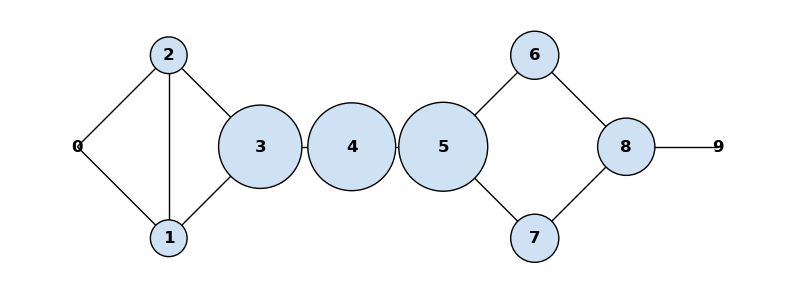

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

node_pos = {
  0: (0, 2), 1: (1, 1), 2: (1, 3), 3: (2, 2), 4: (3, 2),
  5: (4, 2), 6: (5, 3), 7:(5, 1), 8: (6, 2), 9: (7, 2)}
nx.draw(G, pos=node_pos, nodelist=G.nodes, 
  node_size=[200*size for size in betweenness_centrality.values()],
  with_labels=True, font_weight="bold", 
  node_color="#cfe2f3", edgecolors="k", ax=ax)

ax.set_aspect("equal")
ax.set_ylim([0.5, 3.5])
print("The DataSciencester network sized by betweenness centrality")
plt.show(fig)